# Import + Install Libraries

In [1]:
# Import Common Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sb
import io
import re
from random import randint

# install
!pip install git+https://github.com/huggingface/transformers
!pip install english-words

import tensorflow_datasets as tfds
from keras.preprocessing.sequence import pad_sequences
from transformers import TFBertForSequenceClassification, BertTokenizer
from english_words import english_words_set

# Since the data size is big, we will need to use a GPU

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-pvoh29ky
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-pvoh29ky
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 3.3 MB 26.5 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 
     |████████████████████████████████| 596 kB 41.3 MB/s 
  Created wheel for transformers: filename=transformers-4.12.0.dev0-py3-none-any.whl size=2993907 sha256=7031f21460391b409b61bf468fe32f57bb4a303e8d3993e3b61c8ce008af43e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-675fwax6/wheels/35/2e/a7/d819e3310040329f0f47e57c9e3e7a7338aa5e74c49acfe522
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uni

# Data Pre-processing

In [2]:
# In our project, we have performed the data splitting, so we won't need to do the train_test_split anymore.

train = pd.read_csv("train_text_emoji_clean.csv")
test = pd.read_csv("test_text_emoji_clean.csv")
valid = pd.read_csv("valid_text_emoji_clean.csv")

# Remove usernames + punctuations + (numbers) + space + mis-spelling

for i in range(len(train)):
    message = train["tweets"][i]
    clean_message = message.split(":", 1)
    if len(clean_message) > 1:
        train["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[1])))
    else:
        train["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[0])))

for i in range(len(test)):
    message = test["tweets"][i]
    clean_message = message.split(":", 1)
    if len(clean_message) > 1:
        test["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[1])))
    else:
        test["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[0])))

    
for i in range(len(valid)):
    message = valid["tweets"][i]
    clean_message = message.split(":", 1)
    if len(clean_message) > 1:
        valid["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[1])))
    else:
        valid["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[0])))

# Remove all rows that has more than 1 emoji representations

train = train[train['annotations'].map(len) == 1]
test = test[test['annotations'].map(len) == 1]
valid = valid[valid['annotations'].map(len) == 1]

# Reset the index after dropping several rows

train = train.reset_index()
test = test.reset_index()
valid = valid.reset_index()

# Assign the tweets as the dataset for the model

X_train = train["tweets"]
X_test = test["tweets"]
X_valid = valid["tweets"]

# Encode the emojis

train['classification'] = pd.factorize(train["annotations"])[0]
test['classification'] = pd.factorize(test["annotations"])[0]
valid['classification'] = pd.factorize(valid["annotations"])[0]

# Assign the encoded emojis as the labels for the model

y_train = train['classification']
y_test = test['classification']
y_valid = valid['classification']

In [3]:
# Collect all the possible emojis (will be useful for our final prediction function)

emojis = train["annotations"].unique()
emojis

array(['😂', '😭', '😍', '🙄', '❤', '😊', '😩', '🤔', '😘', '🏽', '💯', '🙃'],
      dtype=object)

In [4]:
# Take a look at the training dataset + label

print(X_train)

print("==================================================")

print(y_train)

0                               school is so dead o my god
1        lol Ive been told mine is worse than yours but...
2        Im excited to hear them That shit is going rat...
3        Damn alycia knows everything even indirect tweets
4                               That sound like everything
                               ...                        
52881                 Or That Picture Was Just Cute To You
52882                    Im otw wit some gas still hate me
52883                                  Yeahhh you kinda do
52884                       nothing wit youuuuu raymundooo
52885    dont be that person who parks right next to me...
Name: tweets, Length: 52886, dtype: object
0         0
1         0
2         0
3         0
4         0
         ..
52881    11
52882    11
52883    11
52884    11
52885    11
Name: classification, Length: 52886, dtype: int64


In [5]:
# Take a look at the test dataset + label

print(X_test)

print("==================================================")

print(y_test)

0          The conversation is so deep i saw adele rolling
1         Lord were coo asf lol Just waiting for break ...
2                                                   I cant
3        These little kids talking about going to Canad...
4                                       only would do that
                               ...                        
13480                           The ball hates Croatia smh
13481                        Sexy bitch I hope she bout it
13482    I didnt realize that my tweets were private an...
13483                         lowkey annoyed for no reason
13484                          appreciate it while it last
Name: tweets, Length: 13485, dtype: object
0         0
1         0
2         0
3         0
4         0
         ..
13480    11
13481    11
13482    11
13483    11
13484    11
Name: classification, Length: 13485, dtype: int64


In [6]:
# Take a look at the validation dataset + label

print(X_valid)

print("==================================================")

print(y_valid)

0                             hahahah you guys crack me up
1                                                  Im dead
2                     ate girl The tweet was before TMC pa
3        Also who wouldve thought that Will Griggs on f...
4                             Im not fooling w you tonight
                               ...                        
13476    Hopefully I dont fall asleep in the toilets in...
13477    Excited for the lake Not excited to wake up at...
13478    mom just told me shes leaving early to go to a...
13479          all these double shifts are killing my vibe
13480     I love when my legs are shaved but hate shavi...
Name: tweets, Length: 13481, dtype: object
0         0
1         0
2         0
3         0
4         0
         ..
13476    11
13477    11
13478    11
13479    11
13480    11
Name: classification, Length: 13481, dtype: int64


# Tokenization

In [7]:
# In every BERT model, we need to include the tokens [CLS] & [SEP] for every row's text

sentences_train = ["[CLS] " + query + " [SEP]" for query in X_train]
sentences_test = ["[CLS] " + query + " [SEP]" for query in X_test]
sentences_valid = ["[CLS] " + query + " [SEP]" for query in X_valid]
print(sentences_train[0])
print(sentences_test[0])
print(sentences_valid[0])

[CLS] school is so dead o my god [SEP]
[CLS] The conversation is so deep i saw adele rolling [SEP]
[CLS] hahahah you guys crack me up [SEP]


In [8]:
# Tokenize all the sentences in the training, test, and validation datasets

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts_train = [tokenizer.tokenize(sent) for sent in sentences_train]
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]
tokenized_texts_valid = [tokenizer.tokenize(sent) for sent in sentences_valid]
print ("Tokenize the first sentence of the training:")
print (tokenized_texts_train[0])

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence of the training:
['[CLS]', 'school', 'is', 'so', 'dead', 'o', 'my', 'god', '[SEP]']


# Tokens Padding

In [9]:
# Set the maximum sequence length. 
MAX_LEN = 50

# Pad our input tokens
input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids_valid = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_valid],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids_valid = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_valid]
input_ids_valid = pad_sequences(input_ids_valid, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create Attention Masks (Not Used)

In [10]:
# Create attention masks
attention_masks_train = []
attention_masks_test = []
attention_masks_valid = []

# Create a mask of 1s for each token followed by 0s for padding

for seq in input_ids_train:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_train.append(seq_mask)

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask)

for seq in input_ids_valid:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_valid.append(seq_mask)

# Finalize The Inputs + Labels

In [11]:
train_inputs = input_ids_train
test_inputs = input_ids_test
validation_inputs = input_ids_valid


train_labels = y_train
test_labels = y_test
validation_labels = y_valid


train_masks = attention_masks_train
test_masks = attention_masks_test
validation_masks = attention_masks_valid

# Model Training

In [12]:
# Load tokenizer, model from pretrained model/vocabulary
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=12) # TF added for showing the usage of tensorflow 2.0 version.

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule 
# with tf.device('/device:GPU:0'):
import tensorflow as tf

with tf.device('/device:GPU:0'):
  optimizer = tf.keras.optimizers.Adam(learning_rate=3e-05, epsilon=1e-08, clipnorm=1.0)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [14]:
import os

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callback_1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(x=train_inputs, y=train_labels, validation_data = (validation_inputs, validation_labels), callbacks=[callback_1, callback_2], epochs = 8, batch_size=32)

Epoch 1/8
1653/1653 [==============================] - 1193s 704ms/step - loss: 2.1133 - accuracy: 0.2628 - val_loss: 1.9890 - val_accuracy: 0.3160

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/8
1653/1653 [==============================] - 1163s 703ms/step - loss: 1.8247 - accuracy: 0.3715 - val_loss: 1.9932 - val_accuracy: 0.3190

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/8
1653/1653 [==============================] - 1157s 700ms/step - loss: 1.5376 - accuracy: 0.4709 - val_loss: 2.1303 - val_accuracy: 0.3107

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/8
1653/1653 [==============================] - 1151s 696ms/step - loss: 1.1979 - accuracy: 0.5878 - val_loss: 2.3790 - val_accuracy: 0.3037

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/8
1653/1653 [==============================] - 1150s 696ms/step - loss: 0.9060 - accuracy: 0.6914 - val_loss: 2.7349 - val_accuracy: 0.2844

Epoch 00005: saving model to training_1/cp.ckpt
Epoch 6/8
1653/

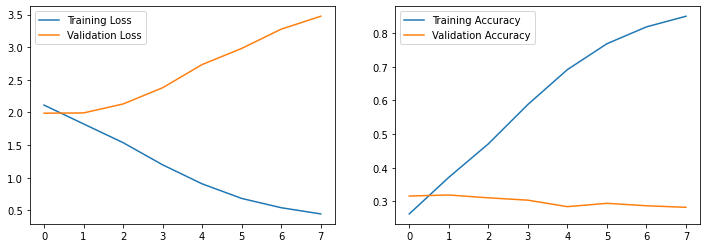

<Figure size 432x288 with 0 Axes>

In [15]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
  plt.subplot(1, 2, i + 1)
  plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
  plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
  plt.legend()
plt.show()
plt.savefig('bert_accuracy.png')

# Model Evaluation

In [16]:
results = model.evaluate(test_inputs, test_labels, batch_size = 32)

print("test loss, test acc:", results)

422/422 [==============================] - 86s 203ms/step - loss: 3.5264 - accuracy: 0.2717
test loss, test acc: [3.526444673538208, 0.27170929312705994]


# Function for Emoji Prediction

In [43]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def emoji_prediction(text):
  clean_message = text.split(":", 1)
  if len(clean_message) > 1:
    final = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[1])))
  else:
    final = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[0])))
  tokenized_text = tokenizer.tokenize("[CLS] "+final+" [SEP]")
  print(tokenized_text)
  input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
  print(input_ids)
  usable = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  result = model.predict(usable)
  chosen = 0
  value = -1.1
  for i in range(len(result.logits[0])):
    if softmax(result.logits[0][i]) > value:
      value = softmax(result.logits[0][i])
      chosen = i
  return emojis[chosen]
emoji_prediction("Hahahaha")

['[CLS]', 'ha', '##ha', '##ha', '##ha', '[SEP]']
[101, 5292, 3270, 3270, 3270, 102]


'😂'